In [1]:
import csv
import itertools

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

import stargaze

In [2]:
with open("./skyserver-dump.csv", newline="") as f:
    reader = csv.DictReader(f)
    plate, mjd, fiber, urls = zip(*[
        (row["plate"], row["mjd"], row["fiber"], row["url"])
        for row in reader
    ])

In [3]:
models = []
redshift = []

for url in urls[:9]:
    with fits.open(url) as hdul:
        models.append(hdul["COADD"].data["model"])
        redshift.append((hdul["SPECOBJ"] if "SPECOBJ" in hdul else hdul["SPALL"]).data["Z"][0])

        first_wavelength = hdul["PRIMARY"].header["COEFF0"]
        dispersion_per_pixel = hdul["PRIMARY"].header["COEFF1"]

num_samples = min(model.shape[0] for model in models)
models = np.vstack(list(model[:num_samples] for model in models))
redshift = np.array(redshift)

In [4]:
temperatures = stargaze.temperatures(models, redshift, first_wavelength, dispersion_per_pixel)

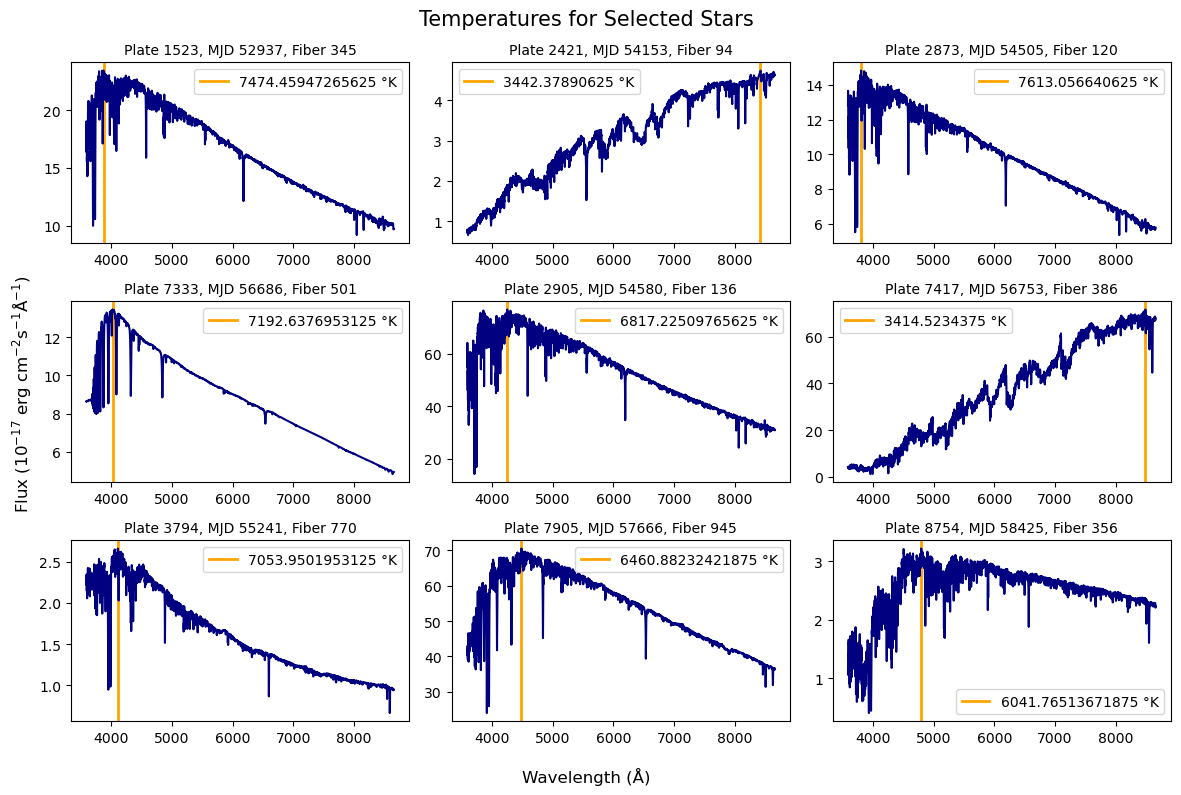

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

x = np.logspace(start=first_wavelength, stop=first_wavelength + num_samples * dispersion_per_pixel, num=num_samples)
wien_b = 28980000

for i, j in itertools.product(range(3), repeat=2):
    ax = axs[j, i]
    idx = i + j * 3
    temp = temperatures[idx]["temperature"]

    ax.set_title(f"Plate {plate[idx]}, MJD {mjd[idx]}, Fiber {fiber[idx]}", size=10)
    ax.axvline(x=wien_b / temp, color="orange", linewidth=2, label=f"{temp} °K")
    ax.plot(x, models[idx], c="navy")
    ax.legend()

fig.suptitle("Temperatures for Selected Stars", size=15)
fig.supxlabel(r"Wavelength (Å)")
fig.supylabel(r"Flux ($10^{-17}\ \text{erg}\ \text{cm}^{-2} \text{s}^{-1} \text{Å}^{-1}$)")
plt.tight_layout()